In [35]:
!pip install wordcloud


[notice] A new release of pip is available: 25.0.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [47]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer
from collections import Counter

In [48]:
train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')
test_labels = pd.read_csv('data/test_labels.csv')

In [70]:
# Saves all plots as images. Need to create img/ folder in root directory for this to work properly
# 1: Save images when run
# 0: Do not save images
SAVE_PLOTS_AS_IMAGES = 1

Xtr, ytr = train, test_labels
labels = test_labels.columns[1:]
corr = Xtr[labels].corr()
print(f'Unique labels: {labels.tolist()}')
print(f'Train data shape: {Xtr.shape}')
print(f'Columns: {Xtr.columns}')
# print(Xtr.head(15))

Unique labels: ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
Train data shape: (159571, 8)
Columns: Index(['id', 'comment_text', 'toxic', 'severe_toxic', 'obscene', 'threat',
       'insult', 'identity_hate'],
      dtype='object')


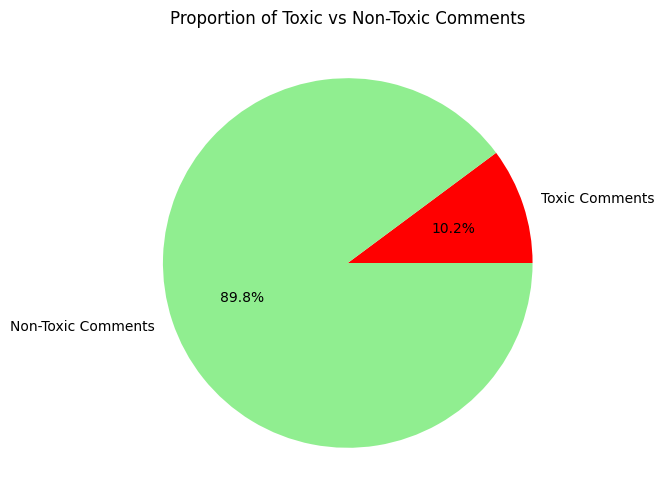

In [59]:
toxic_comments = Xtr[Xtr[labels].sum(axis=1) > 0]
non_toxic_comments = Xtr[Xtr[labels].sum(axis=1) == 0]
counts = [len(toxic_comments), len(non_toxic_comments)]

plt.figure(figsize=(6, 6))
plt.pie(counts, labels=['Toxic Comments', 'Non-Toxic Comments'], colors=['r', 'lightgreen'], autopct='%1.1f%%')
plt.title("Proportion of Toxic vs Non-Toxic Comments")
if SAVE_PLOTS_AS_IMAGES: 
    plt.savefig('img/toxic_vs_nontoxic_counts.png') 
plt.show()

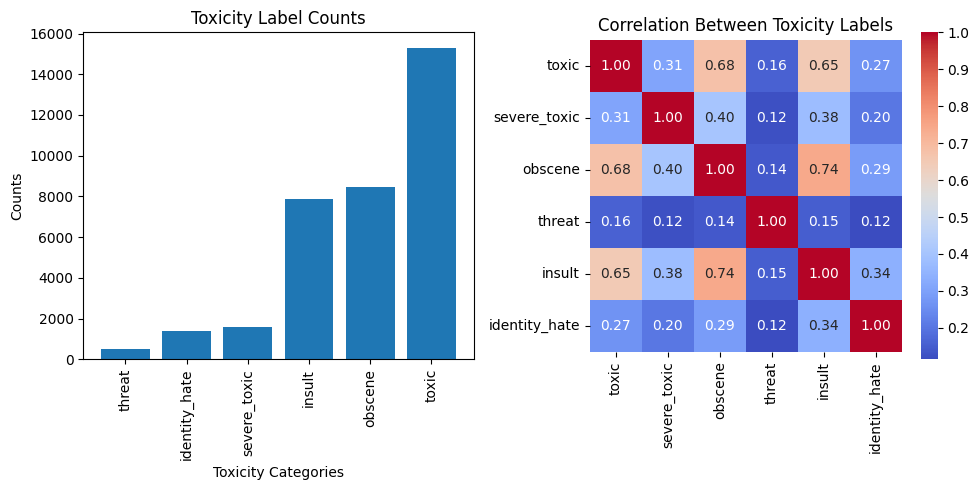

In [60]:
counts = Xtr[labels].sum().sort_values()

fig, axes = plt.subplots(1, 2, figsize=(10, 5))

axes[0].tick_params(axis='x', rotation=90)
axes[0].bar(counts.index, counts.values)
axes[0].set_xlabel('Toxicity Categories')
axes[0].set_ylabel('Counts')
axes[0].set_title('Toxicity Label Counts')

sns.heatmap(
    corr, 
    annot=True, 
    fmt=".2f", 
    cmap="coolwarm", 
    cbar=True, 
    square=True,
    ax=axes[1]
)
axes[1].set_title('Correlation Between Toxicity Labels')
plt.tight_layout()

if SAVE_PLOTS_AS_IMAGES: 
    plt.savefig('img/label_count_information.png') 
plt.show()

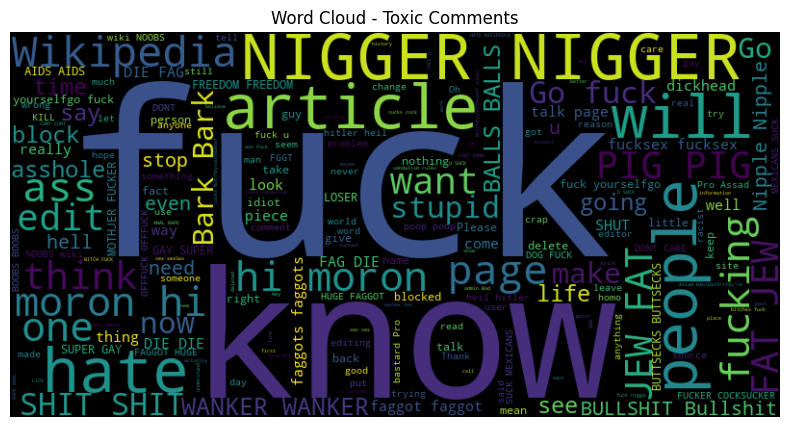

In [67]:
toxic_text = " ".join(Xtr[Xtr['toxic'] == 1]['comment_text'])

wc = WordCloud(width=800, height=400).generate(toxic_text)

plt.figure(figsize=(10,5))
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.title("Word Cloud - Toxic Comments")
if SAVE_PLOTS_AS_IMAGES: 
    plt.savefig('img/toxic_wordcloud.png') 
plt.show()

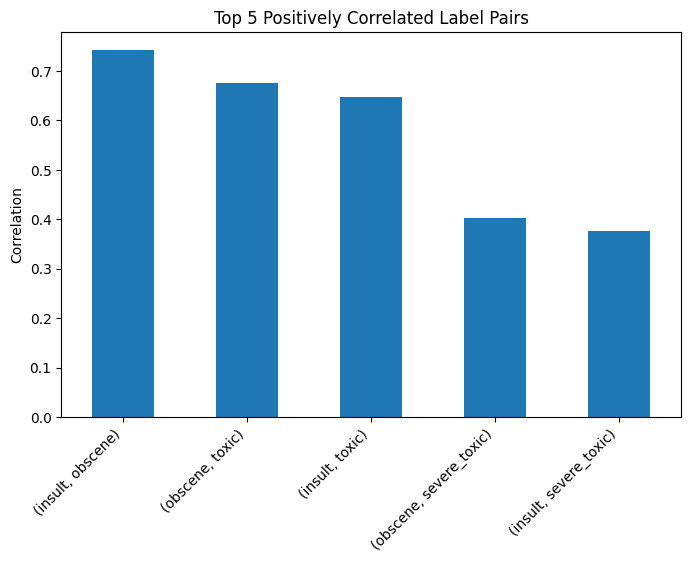

In [62]:
# Flatten upper triangle to ignore duplicates
corr_pairs = corr.where(~np.tril(np.ones(corr.shape)).astype(bool))
corr_pairs = corr_pairs.unstack().dropna()

# Top 5 positive correlations
top_pos = corr_pairs.sort_values(ascending=False).head(5)

plt.figure(figsize=(8,5))
top_pos.plot(kind='bar')
plt.ylabel("Correlation")
plt.title("Top 5 Positively Correlated Label Pairs")
plt.xticks(rotation=45, ha='right')
if SAVE_PLOTS_AS_IMAGES: 
    plt.savefig('img/labels_correlations.png') 
plt.show()

In [63]:
# Only consider top 1000 words to keep it manageable
vectorizer = CountVectorizer(max_features=1000, stop_words='english')
X_words = vectorizer.fit_transform(toxic_comments['comment_text'].astype(str))

# Convert to DataFrame
df_words = pd.DataFrame(X_words.toarray(), columns=vectorizer.get_feature_names_out())

# Count words across all toxic comments
word_counts = df_words.sum().sort_values(ascending=False)
top_words = word_counts.head(20).index

df_top_words = df_words[top_words]

df_combined = pd.concat([toxic_comments[labels].reset_index(drop=True), df_top_words.reset_index(drop=True)], axis=1)

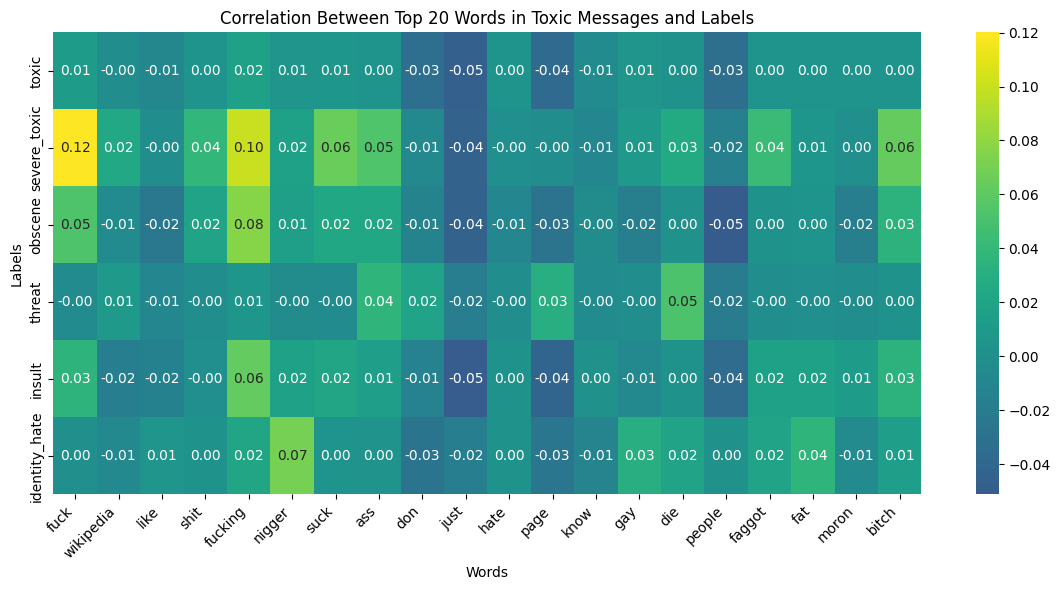

In [64]:
correlations = df_combined.corr().loc[labels, top_words]  # rows=labels, cols=words

plt.figure(figsize=(14,6))
sns.heatmap(correlations, annot=True, fmt=".2f", cmap="viridis", center=0)
plt.title("Correlation Between Top 20 Words in Toxic Messages and Labels")
plt.xlabel("Words")
plt.ylabel("Labels")
plt.xticks(rotation=45, ha='right')

if SAVE_PLOTS_AS_IMAGES: 
    plt.savefig('img/word_label_counts_heatmap.png') 
plt.show()

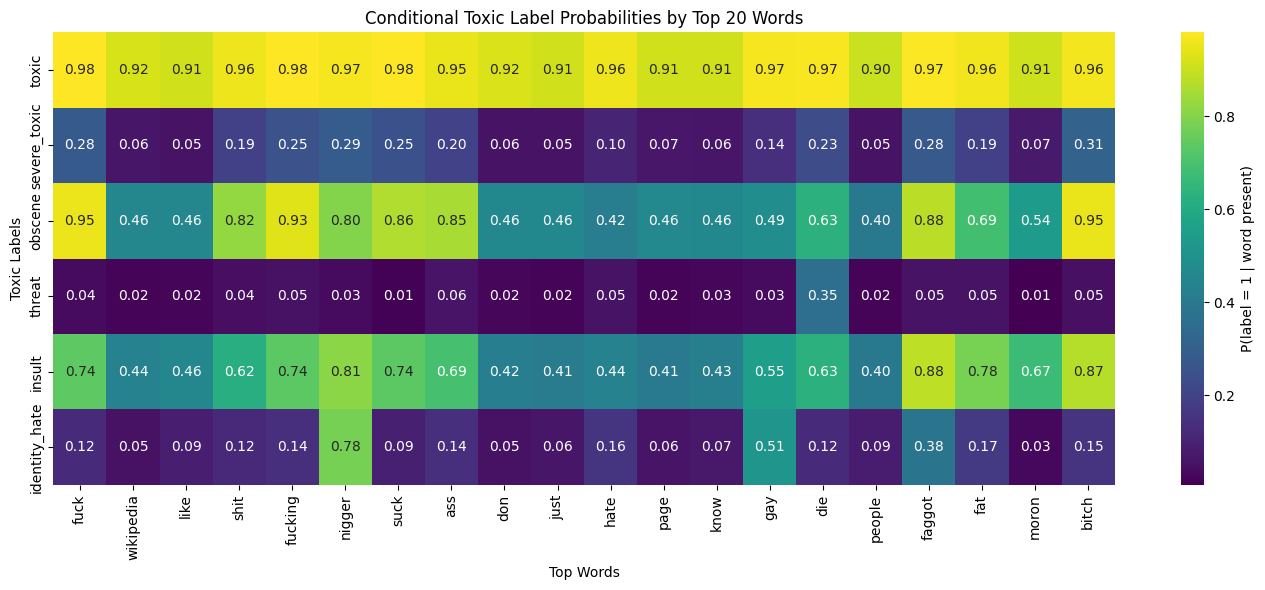

In [65]:


label_df = df_combined[labels]
word_df = df_combined[top_words]

# Compute conditional probability: P(label = 1 | word present)
conditional_matrix = pd.DataFrame(index=labels, columns=top_words, dtype=float)

for lbl in labels:
    for w in top_words:
        mask = word_df[w] > 0
        if mask.sum() == 0:
            conditional_matrix.loc[lbl, w] = 0.0
        else:
            conditional_matrix.loc[lbl, w] = label_df.loc[mask, lbl].mean()

# Plot heat map
plt.figure(figsize=(14, 6))
sns.heatmap(
    conditional_matrix,
    cmap="viridis",
    annot=True,
    fmt=".2f",
    cbar_kws={"label": "P(label = 1 | word present)"}
)
plt.title("Conditional Toxic Label Probabilities by Top 20 Words")
plt.xlabel("Top Words")
plt.ylabel("Toxic Labels")
plt.tight_layout()
if SAVE_PLOTS_AS_IMAGES: 
    plt.savefig('img/word_label_heatmap.png') 
plt.show()



In [71]:
n_labels = len(labels)

# Evenly spaced around a circle (hexagon)
angles = np.linspace(0, 2*np.pi, n_labels, endpoint=False)
corner_coords = np.stack([np.cos(angles), np.sin(angles)], axis=1)  # shape: (6,2)


In [72]:
# y = binary label matrix: shape (n_comments, 6)
y = toxic_comments[labels].values

# Weighted average of corners
comment_coords = y @ corner_coords

# Normalize by number of labels per comment
label_counts = y.sum(axis=1)[:, None]
comment_coords /= np.clip(label_counts, 1, None)  # avoid division by zero

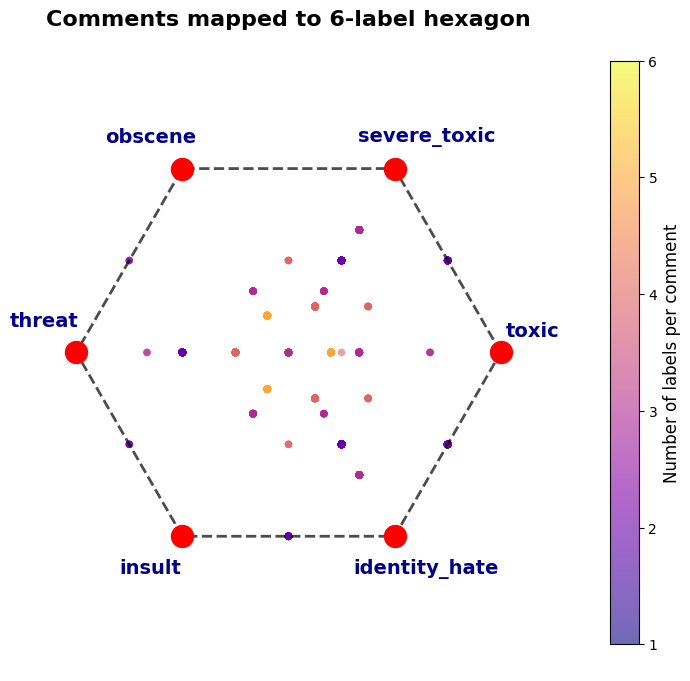

In [85]:
plt.figure(figsize=(7,7))

# Scatter plot
sc = plt.scatter(
    comment_coords[:,0], comment_coords[:,1],
    c=label_counts.flatten(), cmap='plasma', alpha=0.6, s=30,
    edgecolors='none'
)

# Draw hexagon outline
hexagon = np.vstack([corner_coords, corner_coords[0]])
plt.plot(hexagon[:,0], hexagon[:,1], color='black', lw=2, linestyle='--', alpha=0.7)

# Plot label corners with manual padding
for i, lbl in enumerate(labels):
    x, y = corner_coords[i]
    plt.scatter(x, y, color='red', s=250, zorder=5)

    # Adjust text position based on quadrant
    offset_x = 0.15 * np.sign(x)  # push right if x>0, left if x<0
    offset_y = 0.15 * np.sign(y)  # push up if y>0, down if y<0

    # If x or y is zero (middle horizontal or vertical), slightly adjust manually
    if x == 0:
        offset_x = 0
    if y == 0:
        offset_y = 0.1  # small upward shift

    plt.text(x + offset_x, y + offset_y, lbl,
             ha='center', va='center', fontsize=14, fontweight='bold', color='darkblue')

# Colorbar with extra padding
cbar = plt.colorbar(sc, fraction=0.05, pad=0.15)
cbar.set_label("Number of labels per comment", fontsize=12)

plt.title("Comments mapped t", fontsize=16, fontweight='bold')
plt.axis('equal')
plt.axis('off')
plt.tight_layout()
plt.show()
